In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
import pyhalofit
import sys

#sys.path.append('../hscy1/3_meas_vs_theory/wl')
#sys.path.append('../hscy1/3_meas_vs_theory/')
from wl.ximod import *
import wl.pltutil as pltutil

import os
import gc

from scipy.interpolate import InterpolatedUnivariateSpline as ius

In [5]:
class Interp1d(object):
    def __init__(self, angle, spec, bounds_error=False):
        if np.all(spec > 0):
            self.interp_func = interp1d(
                np.log(angle),
                np.log(spec),
                bounds_error=bounds_error,
                fill_value=-np.inf,
            )
            self.interp_type = "loglog"
            self.x_func = np.log
            self.y_func = np.exp
        elif np.all(spec < 0):
            self.interp_func = interp1d(
                np.log(angle),
                np.log(-spec),
                bounds_error=bounds_error,
                fill_value=-np.inf,
            )
            self.interp_type = "minus_loglog"
            self.x_func = np.log
            self.y_func = lambda y: -np.exp(y)
        else:
            self.interp_func = interp1d(
                np.log(angle), spec, bounds_error=bounds_error, fill_value=0.0
            )
            self.interp_type = "log_ang"
            self.x_func = np.log
            self.y_func = lambda y: y

    def __call__(self, angle):
        interp_vals = self.x_func(angle)
        try:
            spec = self.y_func(self.interp_func(interp_vals))
        except ValueError:
            interp_vals[0] *= 1 + 1.0e-9
            interp_vals[-1] *= 1 - 1.0e-9
            spec = self.y_func(self.interp_func(interp_vals))
        return spec

In [11]:
Dir1=  'mockana_ztrue1'
z_lin= np.loadtxt(os.path.join(Dir1,'matter_power_lin/z.txt'))

In [ ]:
def convert_decosmo2halofitcosmo(decosmo, mnu=0.06):
    """Converts camb cosmology list to pyhalofit cosmology dict.
    """
    omnuh2 = 0.00064*(mnu/0.06)
    decosmo = decosmo.flatten()
    halofitcosmo = dict()
    halofitcosmo['Omega_de0'] = decosmo[2]
    halofitcosmo['w0'] = decosmo[5]
    halofitcosmo['h'] = ((omnuh2+decosmo[0]+decosmo[1])/(1.0-decosmo[2]))**0.5
    halofitcosmo['wa'] = 0
    halofitcosmo['Omega_K0'] = 0
    return halofitcosmo

nz  = 140
mnu = 0.0
cparam = np.array([0.02254,0.11417,0.721,3.083548,0.97,-1.])
linear_power = camb_class()
linear_power.set_cosmology(cparam, mnu=mnu, omk=0.0)
zl = np.concatenate([np.logspace(-3,1, nz)])
linear_power.init_pklin_array(zl)

halofit = pyhalofit.halofit()
halofit.set_cosmology(convert_decosmo2halofitcosmo(cparam, mnu=mnu))
cosmo = halofit.cosmo

cosmo_ccl = ccl.Cosmology(Omega_c=0.233, Omega_b=0.046, h=0.7, sigma8=0.82, n_s=0.97,
                          matter_power_spectrum='halofit')
fig, axs = plt.subplots(nrows=2, ncols=7, figsize=(40, 15),
                       gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.1})
k = np.logspace(np.log10(1e-3), np.log10(15), 10000) # 1/Mpc

for ix in range(7):
    iz = 40*ix
    z = z_lin[iz]
    # units of k is h/Mpc in pyhalofit
    pk_lin = linear_power.get_pklin_array_from_z(k=k/halofit.cosmo.h, z=z)
    halofit.set_pklin(k/halofit.cosmo.h, pk_lin, z, unit='h/Mpc')
    
    pk_nl = halofit.get_pkhalo()/ halofit.cosmo.h ** 3 # make sure the output unit of Pk is the same as ccl
    pk_nl_ccl = ccl.nonlin_matter_power(cosmo_ccl, k, 1./(1.+z))
    
    
    top, bot = axs[0, ix], axs[1, ix]
    
    top.loglog(k, pk_nl_ccl, label='ccl')
    top.loglog(k , pk_nl , '.', label='pyhalofit', markersize=0.1, zorder=10)
    inter = Interp1d(k, pk_nl)
    print(inter.interp_type)
    top.loglog(k, inter(k), label='interpolation')
    top.set_title(r'z=%.2f' % z,fontsize=20)
    top.grid()
    top.set_xlim(1e-3, 10)
    top.legend()
    
    bot.semilogx(k, pk_nl_ccl / pk_nl  - 1)
    bot.set_ylabel('pk_ccl / pk_halofit - 1', fontsize=12)
    bot.set_ylim(-.2, .2)
    bot.set_xlim(1e-3, 10)
    bot.axhline(0, ls='--', c='black')

Note: redshifts have been re-sorted (earliest first)
loglog
loglog
loglog
loglog
loglog
loglog
loglog


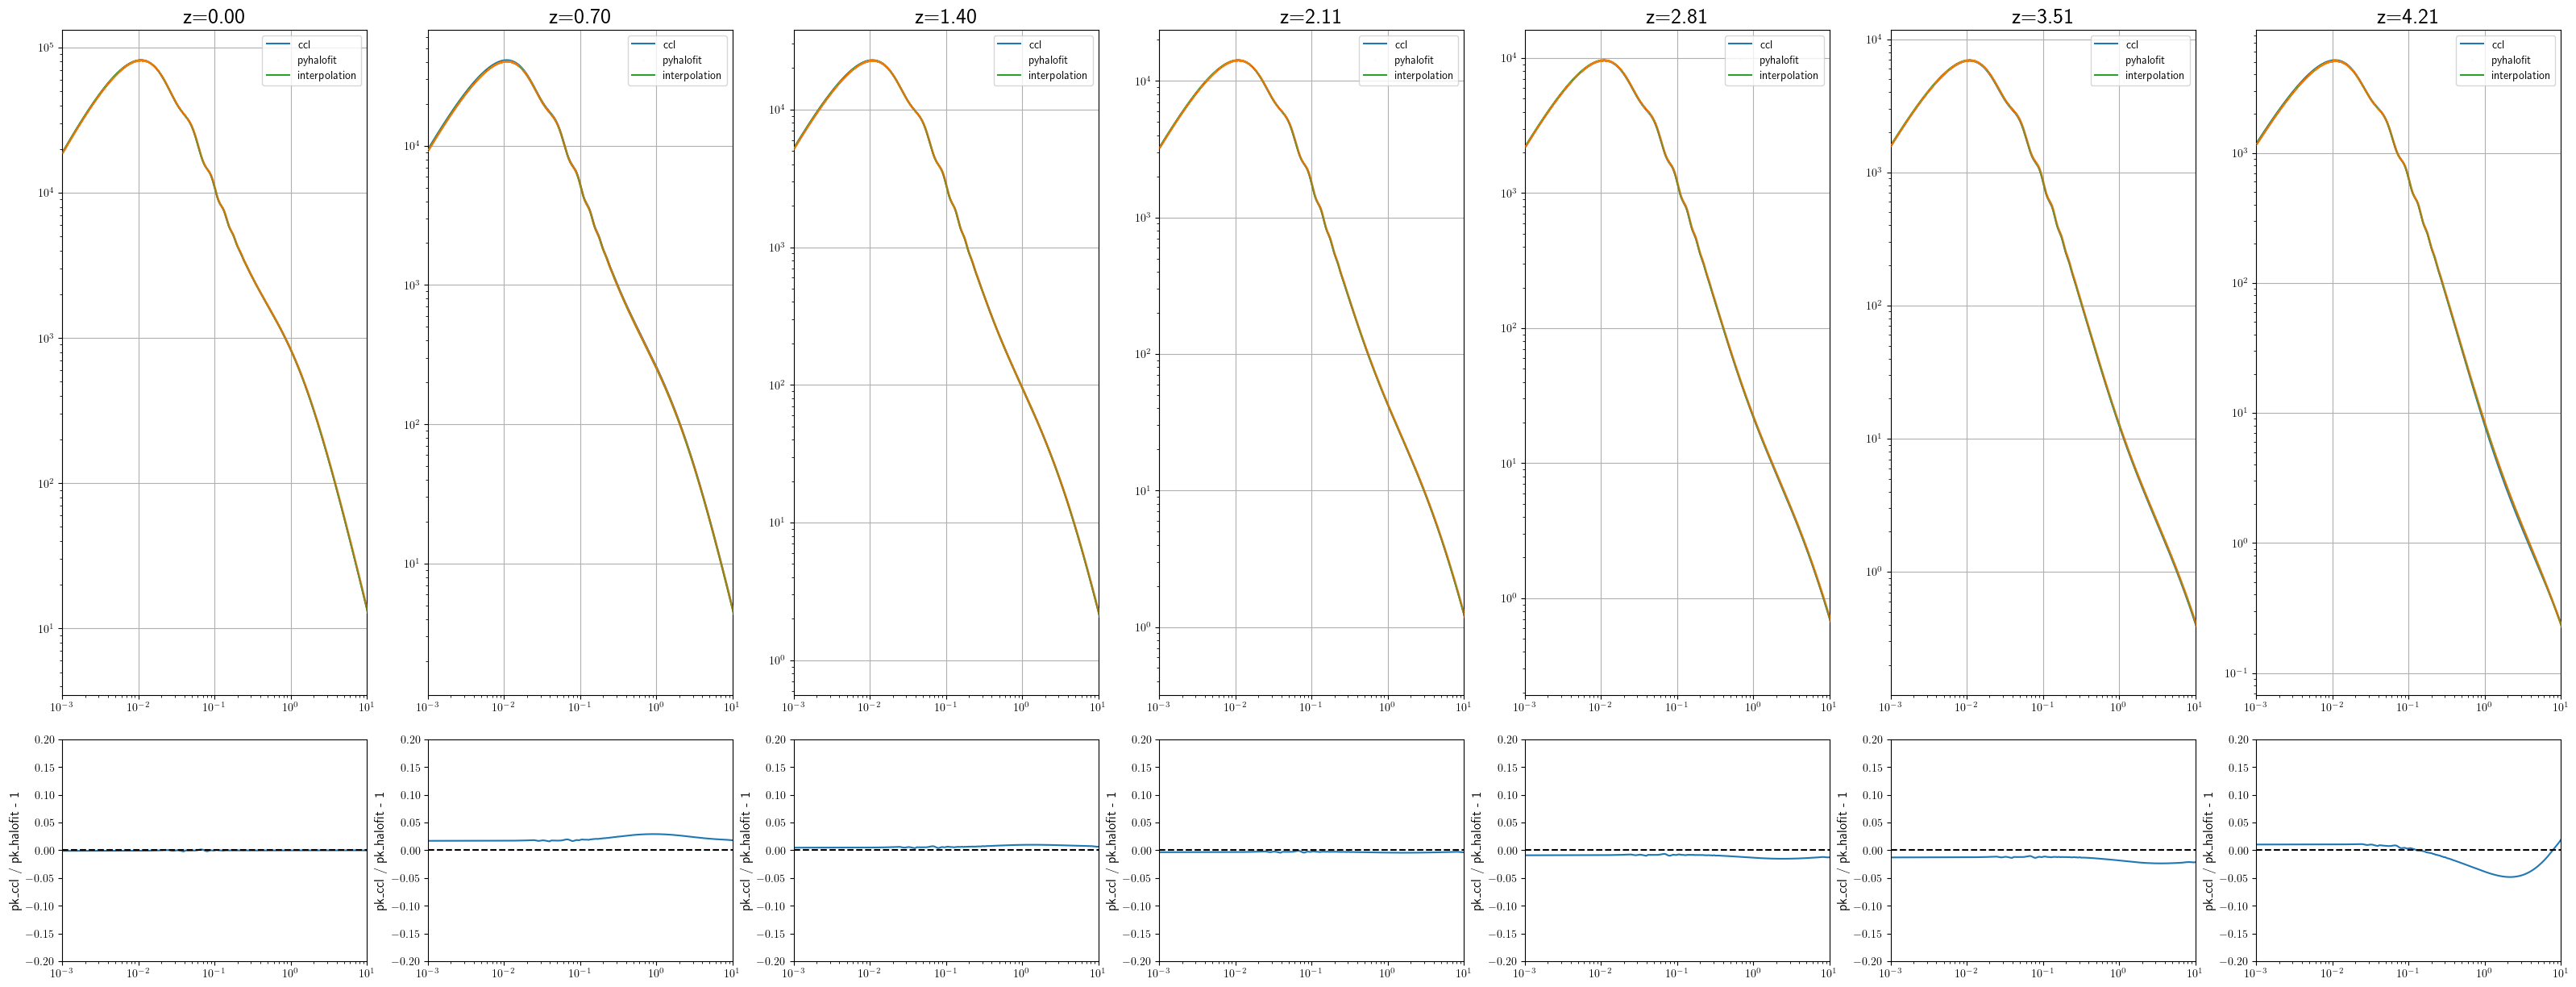

In [25]:
def convert_decosmo2halofitcosmo(decosmo, mnu=0.06):
    """Converts camb cosmology list to pyhalofit cosmology dict.
    """
    omnuh2 = 0.00064*(mnu/0.06)
    decosmo = decosmo.flatten()
    halofitcosmo = dict()
    halofitcosmo['Omega_de0'] = decosmo[2]
    halofitcosmo['w0'] = decosmo[5]
    halofitcosmo['h'] = ((omnuh2+decosmo[0]+decosmo[1])/(1.0-decosmo[2]))**0.5
    halofitcosmo['wa'] = 0
    halofitcosmo['Omega_K0'] = 0
    return halofitcosmo

linear_power = camb_class()
nz  = 72
zl = np.concatenate([np.logspace(-5,-1.001, nz), np.linspace(1e-1, 4.0, nz)])
mnu = 0.0
cparam = np.array([0.02254,0.11417,0.721,3.083548,0.97,-1.])
linear_power.set_cosmology(cparam, mnu=mnu, omk=0.0)
linear_power.init_pklin_array(zl)

halofit = pyhalofit.halofit()
halofit.set_cosmology(convert_decosmo2halofitcosmo(cparam, mnu=mnu))
cosmo = halofit.cosmo

cosmo_ccl = ccl.Cosmology(Omega_c=0.233, Omega_b=0.046, h=0.7, sigma8=0.82, n_s=0.97,
                          matter_power_spectrum='halofit')
fig, axs = plt.subplots(nrows=2, ncols=7, figsize=(40, 15),
                       gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.1})
k = np.logspace(np.log10(1e-3), np.log10(15), 10000) # 1/Mpc

for ix in range(7):
    iz = 40*ix
    z = z_lin[iz]
    # units of k is h/Mpc in pyhalofit
    pk_lin = linear_power.get_pklin_array_from_z(k=k/halofit.cosmo.h, z=z)
    halofit.set_pklin(k/halofit.cosmo.h, pk_lin, z, unit='h/Mpc')
    
    pk_nl = halofit.get_pkhalo()/ halofit.cosmo.h ** 3 # make sure the output unit of Pk is the same as ccl
    pk_nl_ccl = ccl.nonlin_matter_power(cosmo_ccl, k, 1./(1.+z))
    
    
    top, bot = axs[0, ix], axs[1, ix]
    
    top.loglog(k, pk_nl_ccl, label='ccl')
    top.loglog(k , pk_nl , '.', label='pyhalofit', markersize=0.1, zorder=10)
    inter = Interp1d(k, pk_nl)
    print(inter.interp_type)
    top.loglog(k, inter(k), label='interpolation')
    top.set_title(r'z=%.2f' % z,fontsize=20)
    top.grid()
    top.set_xlim(1e-3, 10)
    top.legend()
    
    bot.semilogx(k, pk_nl_ccl / pk_nl  - 1)
    bot.set_ylabel('pk_ccl / pk_halofit - 1', fontsize=12)
    bot.set_ylim(-.2, .2)
    bot.set_xlim(1e-3, 10)
    bot.axhline(0, ls='--', c='black')

Note: redshifts have been re-sorted (earliest first)
loglog
loglog
loglog
loglog
loglog
loglog
loglog


/tmp/ipykernel_1070165/473480045.py:53: RuntimeWarning: divide by zero encountered in true_divide
  bot.semilogx(k, pk_nl_ccl / inter(k) - 1)


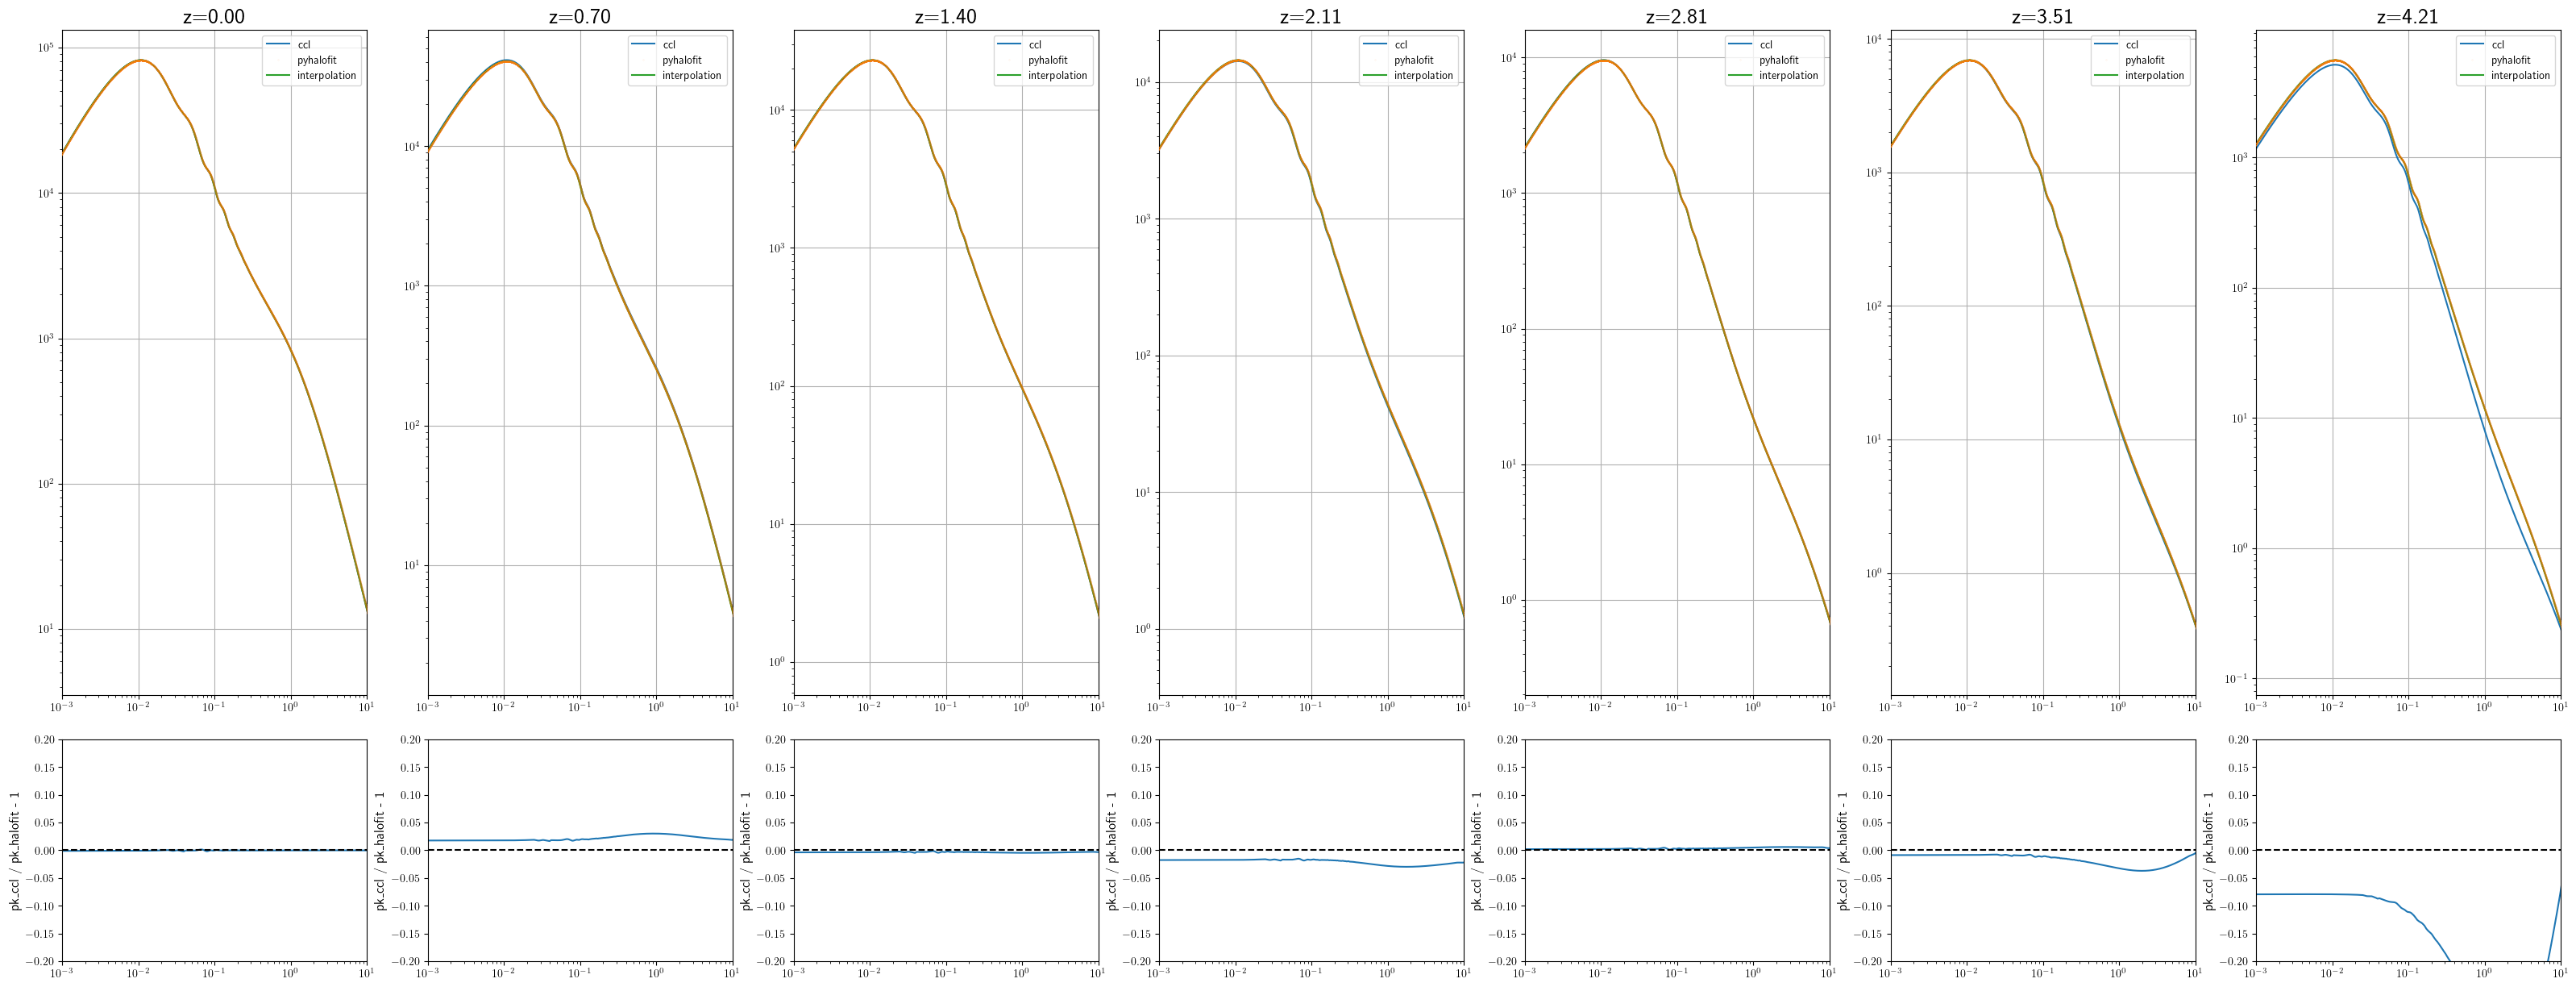

In [18]:
def convert_decosmo2halofitcosmo(decosmo, mnu=0.06):
    """Converts camb cosmology list to pyhalofit cosmology dict.
    """
    omnuh2 = 0.00064*(mnu/0.06)
    decosmo = decosmo.flatten()
    halofitcosmo = dict()
    halofitcosmo['Omega_de0'] = decosmo[2]
    halofitcosmo['w0'] = decosmo[5]
    halofitcosmo['h'] = ((omnuh2+decosmo[0]+decosmo[1])/(1.0-decosmo[2]))**0.5
    halofitcosmo['wa'] = 0
    halofitcosmo['Omega_K0'] = 0
    return halofitcosmo

linear_power = camb_class()
nz=70
mnu = 0.0
cparam = np.array([0.02254,0.11417,0.721,3.083548,0.97,-1.])
linear_power.set_cosmology(cparam, mnu=mnu, omk=0.0)
zl = np.concatenate([np.logspace(-7,-1.1, nz), np.linspace(1e-1, 4.0, nz)])
linear_power.init_pklin_array(zl)

halofit = pyhalofit.halofit()
halofit.set_cosmology(convert_decosmo2halofitcosmo(cparam, mnu=mnu))
cosmo = halofit.cosmo

cosmo_ccl = ccl.Cosmology(Omega_c=0.233, Omega_b=0.046, h=0.7, sigma8=0.82, n_s=0.97,
                          matter_power_spectrum='halofit')
fig, axs = plt.subplots(nrows=2, ncols=7, figsize=(40, 15),
                       gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.1})
k = np.logspace(np.log10(1e-3), np.log10(15), 10000) # 1/Mpc
for ix in range(7):
    iz = 40*ix
    z = z_lin[iz]
    pk_lin = linear_power.get_pklin_array_from_z(k=k, z=z)
    halofit.set_pklin(k, pk_lin, z, unit='h/Mpc')
    
    pk_nl = halofit.get_pkhalo()
    pk_nl_ccl = ccl.nonlin_matter_power(cosmo_ccl, k, 1./(1.+z))
    
    
    top, bot = axs[0, ix], axs[1, ix]
    
    top.loglog(k, pk_nl_ccl, label='ccl')
    top.loglog(k * halofit.cosmo.h, pk_nl / halofit.cosmo.h ** 3, '.', label='pyhalofit', markersize=0.1, zorder=10)
    inter = Interp1d(k * halofit.cosmo.h, pk_nl / halofit.cosmo.h ** 3)
    print(inter.interp_type)
    top.loglog(k, inter(k), label='interpolation')
    top.set_title(r'z=%.2f' % z,fontsize=20)
    top.grid()
    top.set_xlim(1e-3, 10)
    top.legend()
    
    bot.semilogx(k, pk_nl_ccl / inter(k) - 1)
    bot.set_ylabel('pk_ccl / pk_halofit - 1', fontsize=12)
    bot.set_ylim(-.2, .2)
    bot.set_xlim(1e-3, 10)
    bot.axhline(0, ls='--', c='black')

Note: redshifts have been re-sorted (earliest first)
loglog
loglog
loglog
loglog
loglog
loglog
loglog


/tmp/ipykernel_1070165/2624481830.py:52: RuntimeWarning: divide by zero encountered in true_divide
  bot.semilogx(k, pk_nl_ccl / inter(k) - 1)


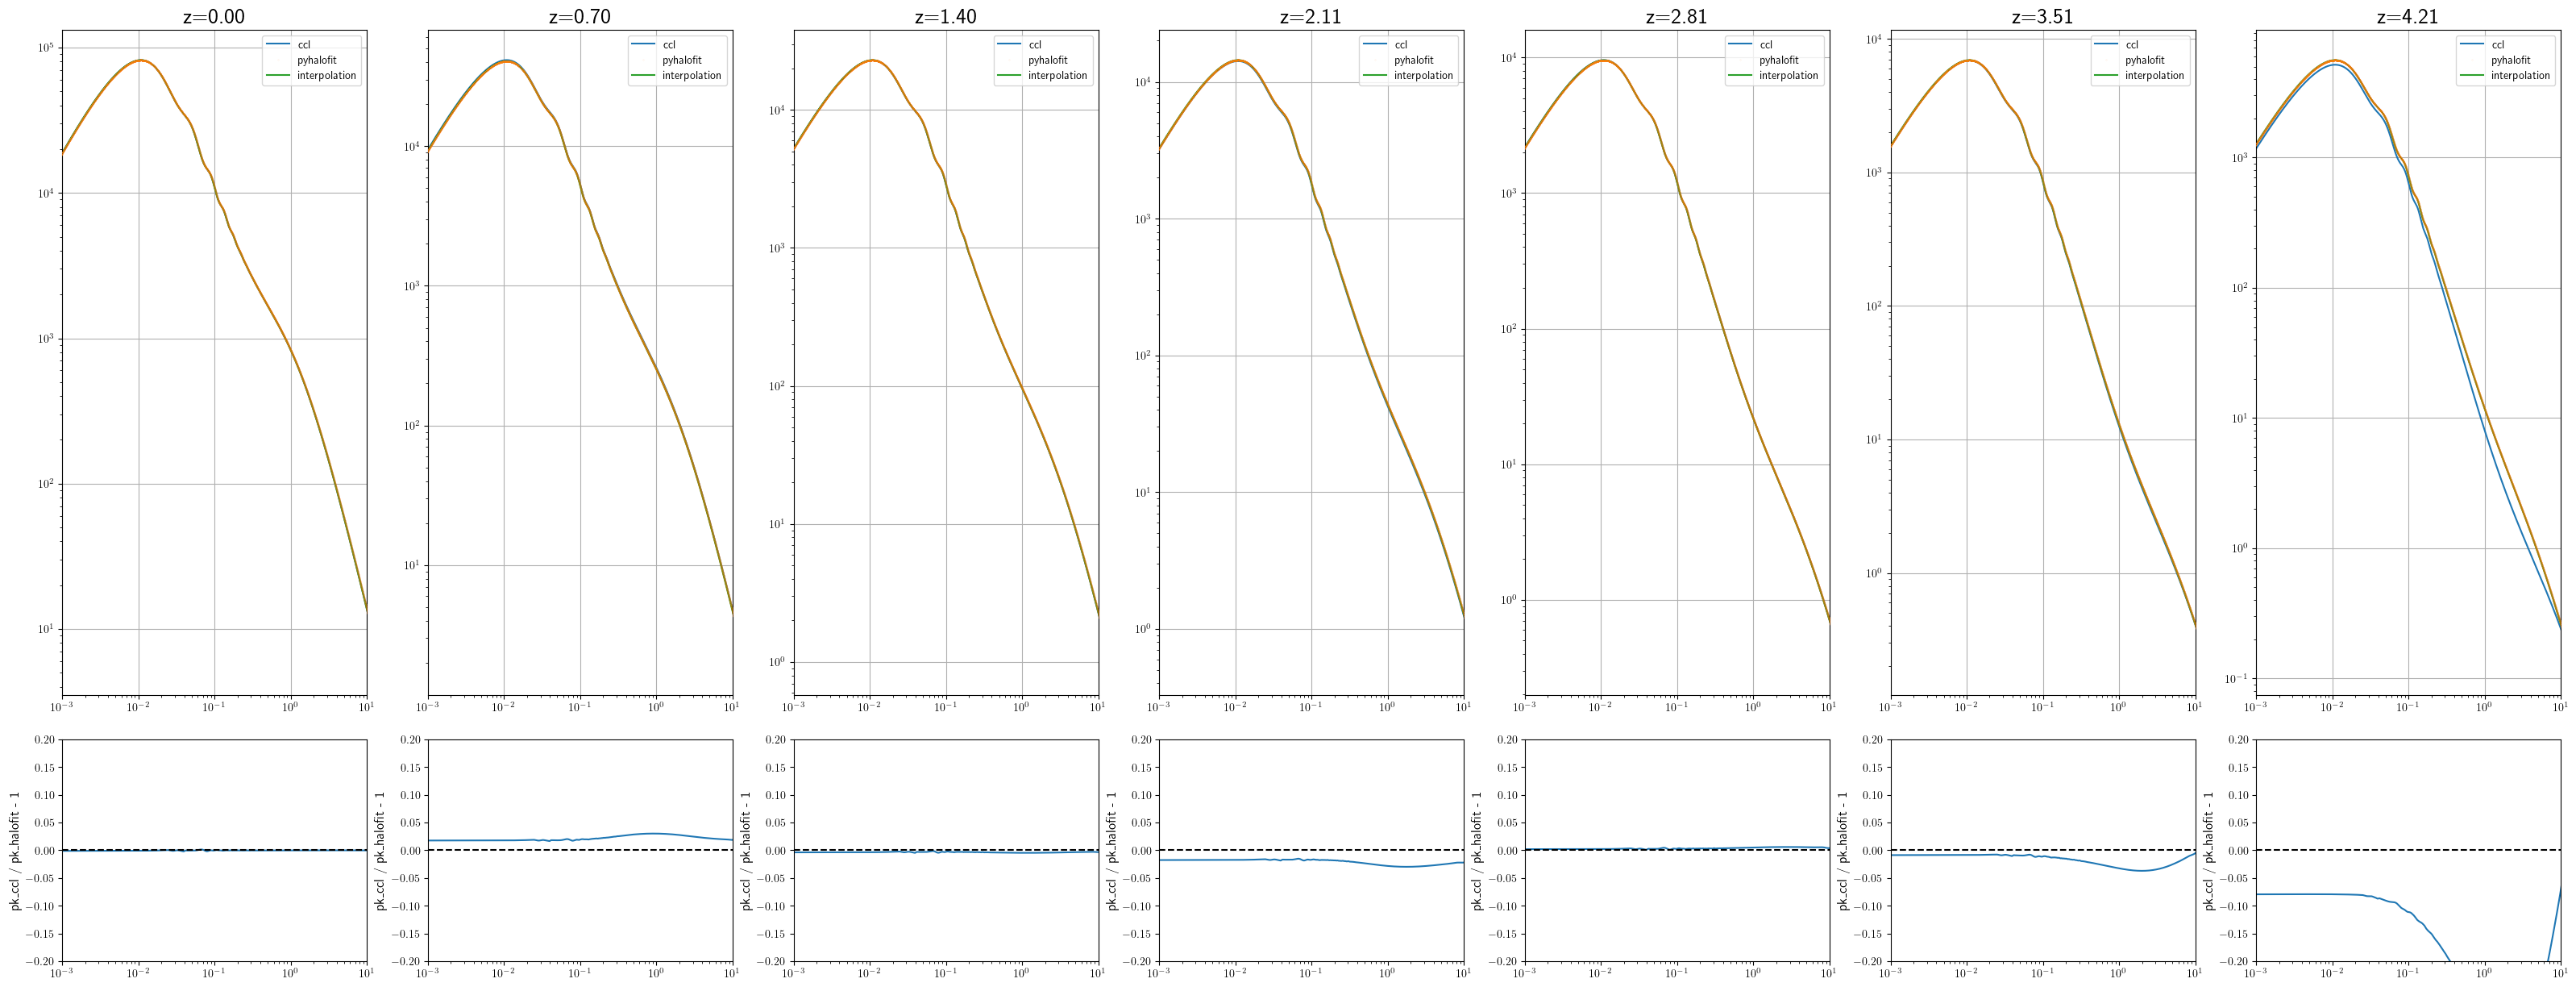

In [12]:
def convert_decosmo2halofitcosmo(decosmo, mnu=0.06):
    """Converts camb cosmology list to pyhalofit cosmology dict.
    """
    omnuh2 = 0.00064*(mnu/0.06)
    decosmo = decosmo.flatten()
    halofitcosmo = dict()
    halofitcosmo['Omega_de0'] = decosmo[2]
    halofitcosmo['w0'] = decosmo[5]
    halofitcosmo['h'] = ((omnuh2+decosmo[0]+decosmo[1])/(1.0-decosmo[2]))**0.5
    halofitcosmo['wa'] = 0
    halofitcosmo['Omega_K0'] = 0
    return halofitcosmo

linear_power = camb_class()
nz=70
mnu = 0.0
cparam = np.array([0.02254,0.11417,0.721,3.083548,0.97,-1.])
linear_power.set_cosmology(cparam, mnu=mnu, omk=0.0)
zl = np.concatenate([np.logspace(-7,-1.1, nz), np.linspace(1e-1, 4.0, nz)])
linear_power.init_pklin_array(zl)

halofit = pyhalofit.halofit()
halofit.set_cosmology(convert_decosmo2halofitcosmo(cparam, mnu=mnu))
cosmo = halofit.cosmo

cosmo_ccl = ccl.Cosmology(Omega_c=0.233, Omega_b=0.046, h=0.7, sigma8=0.82, n_s=0.97,
                          matter_power_spectrum='halofit')
fig, axs = plt.subplots(nrows=2, ncols=7, figsize=(40, 15),
                       gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.1})
k = np.logspace(np.log10(1e-3), np.log10(15), 10000) # 1/Mpc
for ix in range(7):
    iz = 40*ix
    z = z_lin[iz]
    pk_lin = linear_power.get_pklin_array_from_z(k=k, z=z)
    halofit.set_pklin(k, pk_lin, z, unit='h/Mpc')
    
    pk_nl = halofit.get_pkhalo()
    pk_nl_ccl = ccl.nonlin_matter_power(cosmo_ccl, k, 1./(1.+z))
    
    
    top, bot = axs[0, ix], axs[1, ix]
    
    top.loglog(k, pk_nl_ccl, label='ccl')
    top.loglog(k * halofit.cosmo.h, pk_nl / halofit.cosmo.h ** 3, '.', label='pyhalofit', markersize=0.1, zorder=10)
    inter = Interp1d(k * halofit.cosmo.h, pk_nl / halofit.cosmo.h ** 3)
    print(inter.interp_type)
    top.loglog(k, inter(k), label='interpolation')
    top.set_title(r'z=%.2f' % z,fontsize=20)
    top.grid()
    top.set_xlim(1e-3, 10)
    top.legend()
    
    bot.semilogx(k, pk_nl_ccl / inter(k) - 1)
    bot.set_ylabel('pk_ccl / pk_halofit - 1', fontsize=12)
    bot.set_ylim(-.2, .2)
    bot.set_xlim(1e-3, 10)
    bot.axhline(0, ls='--', c='black')